# Predict technical prices based on historical claims data

Author: Paul St-Georges

Version date: December  2023

Reviewed by: Olga Shpyrko, Maximilian Hudlberger, and Quncai Zou

## Overview

This notebook serves as a comprehensive guide to the intricate world of insurance pricing, leveraging historical claims data for modeling and analysis. The primary objective of this notebook is to enable insurance professionals and data scientists to predict insurance pricing accurately and efficiently with DataRobot platform.

This acclerator does the following:

- Set up the environment for insurance pricing modeling
- Import the necessary libraries and emphasize data preparation for use with DataRobot
- Visualize the distribution of claim amounts
- Create two options for modeling workflows for the insurance pricing project: Pure Premium vs. Frequency and Severity
- Explore different feature list and model customization

### Analyze the results and create business analysis

Following the modeling phases, the accelerator transitions to result analysis and business considerations. It discusses testing the models and computing various business metrics and scenarios. The accelerator also covers how to convert from a technical price to a market premium with the inclusion of fixed expenses and variable costs. This part also includes computing loss ratios by various segments, which is crucial for assessing risk and profitability. Finally, the analysis phase includes a dislocation premium chart to visualizes premium impact.

### Deploy the models in production

After thorough analysis and fine-tuning, the accelerator explains how to deploy developed models into production. This is a critical step for implementing the insurance pricing models in real-world scenarios and utilizing them for decision-making.

### Advanced workflows

The final section of the notebook is dedicated to advanced workflows. It introduces feature discovery using secondary claims databases. This advanced approach can significantly reduce the time investment needed from data scientists and engineers, making it a valuable addition to the insurance pricing modeling process.

## Setup

### Import Libraries

In [56]:
import csv

import datarobot as dr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns

RANDOM_SEED = 321

### Import dataset

In [64]:
df = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/insurance/Car+Insurance+Demo.csv"
)

### Information about the dataset

This is a car insurance dataset with various features related to customers and their insurance policies.

Read below for a high livel description of the features.

- Customer_ID: A unique identifier for each customer.
- EffectiveDate: The date when the insurance policy becomes effective.
- EndDate: The date when the insurance policy ends.
- SumInsured: The total amount of insurance coverage for the customer.
- NoClaimBonus: Bonus percentage given to customers for not filing any claims.
- VehicleMake: The brand or manufacturer of the insured vehicle.
- VehicleModel: The specific model of the insured vehicle.
- EngineCapacity: The engine capacity of the insured vehicle.
- ModelYear: The manufacturing year of the insured vehicle.
- ClientType: Type of client, e.g. retail or commercial.
- DriverDoB: The date of birth of the driver.
- NumberOfDrivers: The number of drivers covered by the insurance.
- CustomerTenure: The duration of the customer's relationship with the insurance company.
- Gender: Gender of the customer.
- MaritalStatus: Marital status of the customer.
- Longitude: Longitude coordinates of the customer's location.
- Latitude: Latitude coordinates of the customer's location.
- PostCode_Aged_18_24: Percentage of people aged 18-24 in the customer's postal code area.
- PostCode_Aged_25_29: Percentage of people aged 25-29 in the customer's postal code area.
- PostCode_Aged_30_39: Percentage of people aged 30-39 in the customer's postal code area.
- PostCode_Aged_40_44: Percentage of people aged 40-44 in the customer's postal code area.
- PostCode_Aged_45_49: Percentage of people aged 45-49 in the customer's postal code area.
- PostCode_Aged_50_59: Percentage of people aged 50-59 in the customer's postal code area.
- PostCode_Aged_60: Percentage of people aged 60 and above in the customer's postal code area.
- PostCode_PersonsPerDwelling: The average number of persons per dwelling in the customer's postal code area.
- PostCode_annualKm: The annual kilometers traveled in the customer's postal code area.
- PostCode_VehiclesPerDwelling: The average number of vehicles per dwelling in the customer's postal code area.
- PostCode_CommuteViaCar: Percentage of people in the customer's postal code area commuting via car.
- DistributionChannel: The channel through which the insurance was distributed, e.g., Vehicle Dealership, Bankassurance, Insurance Broker.
- SydneyRegion: Indicates whether the insured vehicle is in the Sydney region.
- CurrentPremium: The current premium amount the customer is paying.
- ClaimCount: The number of claims filed by the customer.
- IncurredClaims: The total amount claimed by the customer during the policy period.

### Data preparation

The Python code in the following cell performs data preprocessing tasks, including date conversion, handling missing and negative values, and creating new features to enhance the dataset's suitability for further analysis and modeling.

In [66]:
# Data preprocessing:
# 1. Convert date columns to datetime objects for consistency and analysis.
df["EffectiveDate"] = pd.to_datetime(df["EffectiveDate"])
df["DriverDoB"] = pd.to_datetime(df["DriverDoB"])
df["EndDate"] = pd.to_datetime(df["EndDate"])

# 2. Calculate the 'Exposure' feature based on the policy's duration in years, considering the start and end date.
df["Exposure"] = ((df["EndDate"] - df["EffectiveDate"]) / np.timedelta64(1, "D") + 1) / 365

# 3. Handle missing values in 'IncurredClaims' by replacing them with 0.
df["IncurredClaims"] = df["IncurredClaims"].fillna(0)

# 4. Set negative 'IncurredClaims' values to 0 or apply alternative treatment for negative values (dependent on the use case)
df["IncurredClaims"] = np.where(df["IncurredClaims"] < 0, 0, df["IncurredClaims"])

# 5. Remove policies with negative or zero 'Exposure'.
df.drop(df[df["Exposure"] <= 0].index, inplace=True)

# 6. Calculate 'VehicleAge' as the difference between the underwriting year and the vehicle's model year.
df["VehicleAge"] = df["EffectiveDate"].dt.year - df["ModelYear"]

# 7. Set negative 'VehicleAge' values to 0, assuming a new vehicle.
df["VehicleAge"] = np.where(df["VehicleAge"] < 0, 0, df["VehicleAge"])

# 8. Drop the original 'ModelYear' column as 'VehicleAge' now captures the same information.
df.drop(["ModelYear"], axis=1, inplace=True)

# 9. Calculate 'DriverAge' based on the difference between the policy's effective date and the driver's date of birth.
df["DriverAge"] = (df["EffectiveDate"] - df["DriverDoB"]).astype("<m8[Y]")

# 10. Create an 'NCB_offset' feature based on the No Claim Bonus (NCB) discounts.

# The 'NCB_offset' adjusts the model for NCB, particularly for regression problems using the log link function.
df["NCB_offset"] = np.log((100 - df["NoClaimBonus"]) / 100)

# 10. Create underwriting year feature
df["UWYEar"] = df["EffectiveDate"].dt.year

# 11. Drop remaining features

columns_to_drop = ["EffectiveDate", "EndDate", "DriverDoB"]
df = df.drop(columns=columns_to_drop)

In [6]:
# Visualize the changes made to the data
df.head(5)

,Customer_ID,SumInsured,NoClaimBonus,VehicleMake,VehicleModel,EngineCapacity,ClientType,NumberOfDrivers,CustomerTenure,Gender,...,DistributionChannel,SydneyRegion,CurrentPremium,ClaimCount,IncurredClaims,Exposure,VehicleAge,DriverAge,NCB_offset,UWYEar
0,800505,10000,55.0,FORD,Laser,1498,Retail,1,1,F,...,Vehicle Dealership,Y,316.70,0,0.000000,1.000000,16,41.0,-0.798508,2022
1,800507,60000,30.0,FORD,Ranger,2499,Commercial,1,1,C,...,Bankassurance,Y,908.73,1,1372.694185,0.589041,3,NaN,-0.356675,2021
2,800508,180000,0.0,MERCEDES-BENZ,E240,2597,Retail,2,3,F,...,Insurance Broker,Y,2574.95,0,0.000000,1.000000,5,39.0,0.000000,2021
3,800510,130000,25.0,HYUNDAI,Sonata,1998,Commercial,1,24,C,...,Vehicle Dealership,Y,700.48,0,0.000000,1.000000,2,NaN,-0.287682,2022
4,800513,60000,0.0,HONDA,City,1497,Commercial,1,3,C,...,Insurance Broker,Y,1041.30,0,0.000000,1.000000,4,NaN,0.000000,2022


### Create an additional dataframe for severity projects

You need to create a severity dataset by only keeping rows that have a claim in the dataset.

In [7]:
# Create a New DataFrame 'sev' for Severity Analysis:
# This DataFrame is a copy of the original data, retaining all rows for now.

sev = df.copy()

# Filtering rows for Severity Analysis:
# Remove rows where 'ClaimCount' is equal to 0, which implies no claims were made.
sev.drop(sev[sev["ClaimCount"] == 0].index, inplace=True)

### Visualise the distribution of claims amount
As pricing analyst, one might want to make  decisions on capping losses prior to the analysis


(0.9, 1.0)

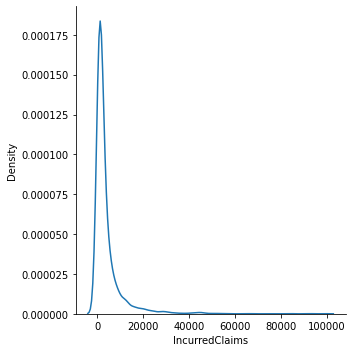

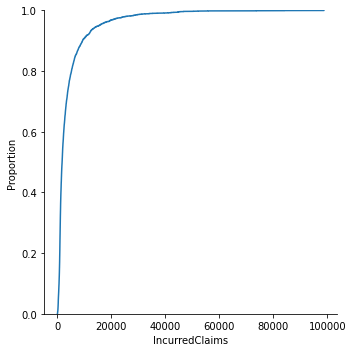

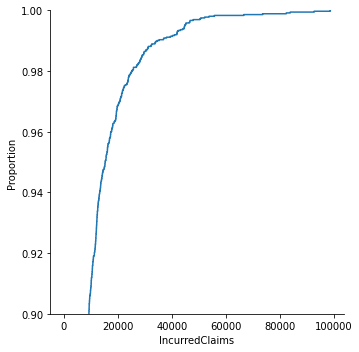

In [8]:
# Visualizing Incurred Claims Distribution for Severity Analysis:

# Create a kernel density estimate (KDE) plot for 'IncurredClaims' in 'sev' DataFrame.
sns.displot(sev, x="IncurredClaims", kind="kde")

# Create an empirical cumulative distribution function (ECDF) plot for 'IncurredClaims'.
sns.displot(sev, x="IncurredClaims", kind="ecdf")

# Create another ECDF plot for 'IncurredClaims' to emphasize percentiles beyond the 90th.
# Adjust the y-axis limit to focus on percentiles post the 90th percentile.
sns.displot(sev, x="IncurredClaims", kind="ecdf")
plt.ylim(0.9, 1)

### Cap large losses for modeling

Pricing analysts might want to model excess losses separately after capping.

In [9]:
# Specify a cap limit for incurred claims that you want to apply.
cap_limit = 15000  # Enter the desired capping amount here.

# Depending on the specific peril being analyzed, it may be necessary to cap very large claims before modeling.
# This operation ensures that any claims exceeding the 'cap_limit' are set to 'cap_limit' for both the 'df' and 'sev' DataFrames.

# On an Incurred Claims dataset:
df["IncurredClaims"] = np.where(df["IncurredClaims"] > cap_limit, cap_limit, df["IncurredClaims"])

# On a Severity dataset:
sev["IncurredClaims"] = np.where(
    sev["IncurredClaims"] > cap_limit, cap_limit, sev["IncurredClaims"]
)

Adding specific targets for  Severity projects


In [58]:
# For Severity (target_sev) project, within the 'sev' DataFrame, the target is the ratio of 'IncurredClaims' to 'ClaimCount'.
sev["target_sev"] = sev["IncurredClaims"] / sev["ClaimCount"]

## Modeling with DataRobot 

### Connect to DataRobot

In [59]:
# Connect to the DataRobot client
dr.Client()

This accelerator offers two modeling options:

- A) Incurred claim (aka pure remium) modeling workflow
- B) Frequency x severity modeling workflow

### Option A - Incurred claim modeling workflow

This option is suitable for incurred claim projects. DataRobot recommend using incurred claims as the target, and using DataRobot advanced options for Exposure and Count of Events (for claim count).

In [12]:
# Create a DataRobot project for Incurred Claims (Pure Premium) Modeling:
# A new project, named "IncurredClaims_Demo," is created using the data from the 'df' DataFrame.

ic_project = dr.Project.create(sourcedata=df, project_name="IncurredClaims_Demo")

# Define an Informative Features List for modeling:
# Extract the 'Informative Features' list from the Incurred Claims project.
informative = [
    feat_list
    for feat_list in ic_project.get_featurelists()
    if feat_list.name == "Informative Features"
][0]

# Create a new Feature List:
# A new feature list, named "new_fl," is created by excluding certain features from the 'informative' list,
# which are not relevant to the pure premium project or could cause leakage

new_fl = ic_project.create_featurelist(
    "new_fl",
    list(
        (
            set(informative.features)
            - {"NoClaimBonus", "IncurredClaims", "CurrentPremium", "Longitude", "Latitude"}
        )
    ),
)


# Set the project's target and initiate Autopilot:
# The project's target is set as 'IncurredClaims,' and Autopilot is initiated for model training.
# Various advanced options, including random seed, exposure, events count, and offset of No claim bonus, are configured.

ic_project.analyze_and_model(
    worker_count=-1,  # Setting worker count to -1 utilizes the maximum available workers.
    max_wait=600,
    target="IncurredClaims",
    advanced_options=dr.AdvancedOptions(
        seed=RANDOM_SEED, exposure="Exposure", events_count="ClaimCount", offset=["NCB_offset"]
    ),
    featurelist_id=new_fl.id,
)

# Wait for AutoPilot to Complete:
# - The code is commented, but you can uncomment it to wait for AutoPilot processes to finish.
# ic_project.wait_for_autopilot()

Project(IncurredClaims_Demo)

## Feature selection

To accomplish feature selection, calculate aggregated Feature Impact using models created during Autopilot.

In [24]:
# For this workflow, select the top five performing models from the project

models = ic_project.get_models()
models = models[:5]
print(models)

[Model('Generalized Additive2 Model (Tweedie Loss: 1.5)'), Model('Frequency-Severity Generalized Additive2 Model'), Model('Generalized Additive Model (Tweedie Loss: 1.5)'), Model('Frequency-Severity eXtreme Gradient Boosted Trees'), Model('eXtreme Gradient Boosted Trees Regressor with Early Stopping (Tweedie Loss: 1.5)')]


### Create a dataframe

Create a dataframe of features' relative rank for the top five models.

In [25]:
all_impact = pd.DataFrame()
for model in models[0:5]:
    # This can take about one minute for each model
    feature_impact = model.get_or_request_feature_impact(max_wait=600)

    # Ready to be converted to dataframe
    df = pd.DataFrame(feature_impact)
    # Track model names and IDs for auditing purposes
    df["model_type"] = model.model_type
    df["model_id"] = model.id
    # By sorting and re-indexing, the new index becomes the 'ranking'
    df = df.sort_values(by="impactUnnormalized", ascending=False)
    df = df.reset_index(drop=True)
    df["rank"] = df.index.values

    # Add to the master list of all models' feature ranks
    all_impact = pd.concat([all_impact, df], ignore_index=True)

### View rankings and distribution
You can find the N features with the highest median ranking and visualize the distributions:

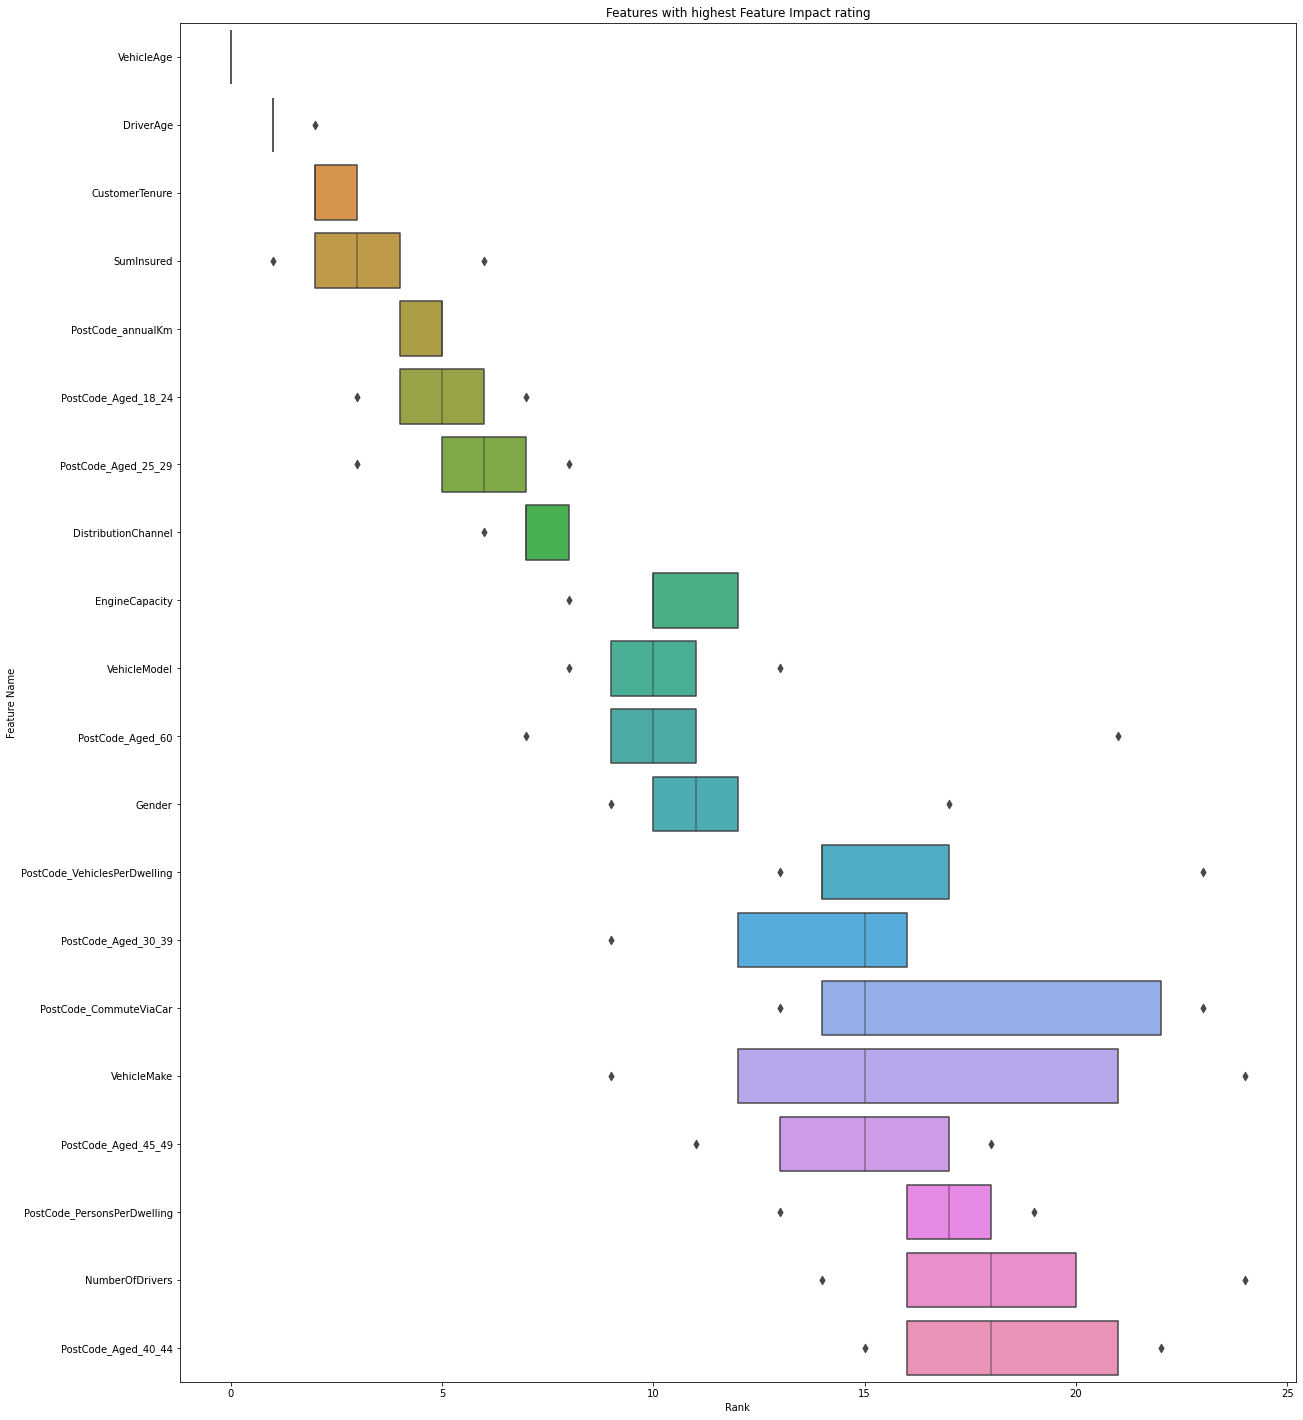

In [26]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger

matplotlib_axes_logger.setLevel("ERROR")

n_feats = 20
top_feats = list(
    all_impact.groupby("featureName").median().sort_values("rank").head(n_feats).index.values
)

top_feat_impact = all_impact.query("featureName in @top_feats").copy()

fig, ax = plt.subplots(figsize=(20, 25))
sns.boxenplot(y="featureName", x="rank", data=top_feat_impact, order=top_feats, ax=ax, orient="h")
plt.title("Features with highest Feature Impact rating")
_ = ax.set_ylabel("Feature Name")
_ = ax.set_xlabel("Rank")

## Train with a different feature list

In addition to the original feature list, you have the flexibility to retrain models using a customized feature list through the API. This approach allows you, for example, to replicate the existing rating structure, which is currently applied to determine car insurance pricing.

In [ ]:
# Define the existing current rating features:
existing_rating = ["VehicleAge", "SumInsured", "DriverAge", "Gender"]

# Create a custom feature list named 'ExistingRating_Structure':
featurelist = ic_project.create_featurelist("ExistingRating_Structure", existing_rating)

# Launch the new rating structure on Frequency, Severity, and Incurred Loss Projects:
ic_project.start_autopilot(featurelist.id)

## Get predictions from the top model on a test dataset

In [67]:
# Using an existing incurred loss project for prediction

# Uncomment to access an existing project set your project ID below
# project = dr.Project.get("6544d5350399d9c87ba81e05")

# Set the 'project' variable to the Incurred Loss project you want to use
project = ic_project

# For testing purposes, use a subset of the training data to simulate predictions
# This subset acts as a placeholder for a genuinely holdout prediction dataset
test_data = df.head(50000)
test_data.reset_index(drop=True, inplace=True)

# Retrieve the top model from the specified project
top_model = project.get_top_model()

# Upload the test data as a dataset within the project
dataset_from_file = project.upload_dataset(test_data, dataset_filename="test data")

# Request predictions using the top model for the uploaded dataset
predict_job_1 = top_model.request_predictions(dataset_from_file.id)

# Retrieve the predictions when the prediction job is complete and display them
predictions = predict_job_1.get_result_when_complete()

display(predictions.head())

,row_id,prediction
0,0,74.880918
1,1,508.133857
2,2,633.537419
3,3,800.577819
4,4,602.757695


## Option B - Frequency x Severity modeling workflow

This option can be used instead of the Incurred Loss / Pure Premium modeling workflow detailed above. This option is another way to model the incurred loss by building a separate project for frequency and severity within DataRobot.

For frequency projects, DataRobot recommends using `Total Claim Count` as the target and then using DataRobot advanced options for Exposure.

In [17]:
# Create a DataRobot Project for Claims Frequency Modeling:
# A new project, named "Claims Frequency Demo," is created using the data from the 'df' DataFrame.

freq_project = dr.Project.create(sourcedata=df, project_name="Claims Frequency Demo")

# Define an Informative Features List for Modeling:
# Extract the 'Informative Features' list from the Incurred Claims project.

informative = [
    feat_list
    for feat_list in freq_project.get_featurelists()
    if feat_list.name == "Informative Features"
][0]

# Create a New Feature List:
# A new feature list, named "new_fl," is created by excluding certain features from the 'informative' list,
# which are not relevant to the frequency project or could cause leakage

new_fl = freq_project.create_featurelist(
    "new_fl",
    list(
        (
            set(informative.features)
            - {
                "ClaimCount",
                "IncurredClaims",
                "NCB_offset",
                "NoClaimBonus",
                "CurrentPremium",
                "Longitude",
                "Latitude",
            }
        )
    ),
)


# Set the Project's Target and Initiate Autopilot:
# The project's target is set as 'target_freq,' and Autopilot is initiated for model training.
# Various advanced options, including random seed, exposure, and offset of No claim bonus, are configured.


freq_project.analyze_and_model(
    target="ClaimCount",
    max_wait=600,
    worker_count=-1,
    advanced_options=dr.AdvancedOptions(
        seed=RANDOM_SEED, exposure="Exposure", offset=["NCB_offset"]
    ),
    featurelist_id=new_fl.id,
)

# Wait for Autopilot to Complete:
# - The code is commented, but you can uncomment it to wait for Autopilot processes to finish.
# freq_project.wait_for_autopilot()

Project(Claims Frequency Demo)

## Severity modeling 

For Severity projects, DataRobot recommends using `Incurred Claims / Claims Count` as the target, and using claim count as weights.

In [18]:
# Create a DataRobot Project for Claims Severity Modeling:
# A new project, named "Claims Severity Demo," is created using the data from the 'sev' DataFrame (df with only  claims )

sev_project = dr.Project.create(sourcedata=sev, project_name="Claims Severity Demo")

# Define an Informative Features List for modeling:
# Extract the 'Informative Features' list from the Severity project.

informative = [
    feat_list
    for feat_list in sev_project.get_featurelists()
    if feat_list.name == "Informative Features"
][0]

# Create a new Feature List:
# A new feature list, named "new_fl," is created by excluding certain features from the 'informative' list,
# which are not relevant to the severity project or could cause leakage

new_fl = sev_project.create_featurelist(
    "new_fl",
    list(
        (
            set(informative.features)
            - {
                "IncurredClaims",
                "NCB_offset",
                "NoClaimBonus",
                "CurrentPremium",
                "Longitude",
                "Latitude",
            }
        )
    ),
)

# Set the Project's Target and Initiate Autopilot:
# The project's target is set as 'target_sev,' and AutoPilot is initiated for model training.
# Various advanced options, including random seed, exposure, and offset of No claim bonus, are configured.

sev_project.analyze_and_model(
    target="target_sev",
    max_wait=600,
    worker_count=-1,
    advanced_options=dr.AdvancedOptions(seed=RANDOM_SEED, weights="ClaimCount"),
    featurelist_id=new_fl.id,
)

# Wait for Autopilot to complete:
# The code is commented, but you can uncomment it to wait for AutoPilot processes to finish.
# sev_project.wait_for_autopilot()

Project(Claims Severity Demo)

## Train with a different feature list

In addition to the original feature list, you have the flexibility to retrain models using a customized feature list through the API. This approach allows you, for example, to replicate the existing rating structure, which is currently applied to determine car insurance pricing.

In [ ]:
# Define the existing current rating features:
existing_rating = ["VehicleAge", "SumInsured", "DriverAge", "Gender"]

# List of projects to update with the new rating structure:
proj_list = [freq_project, sev_project]

# Iterate through the projects:
for proj in proj_list:
    # Create a custom Feature List named 'ExistingRating_Structure':
    featurelist = proj.create_featurelist("ExistingRating_Structure", existing_rating)

    # Launch the new rating structure on Frequency, Severity, and Incurred Loss projects:
    proj.start_autopilot(featurelist.id)

## Get predictions from the top model on a test dataset

In [359]:
# Predictions from existing projects and combining results

# To access existing Frequency and Severity projects, set the respective project IDs below.
# freq_proj = dr.Project.get("648ada178e3cbea9981ae5dc")
# sev_proj = dr.Project.get("648adad004cdaea9a71ae8ce")

# For testing purposes, use a subset of the training data to simulate predictions.
# This subset acts as a placeholder for a genuinely held-out prediction dataset.

test_data = df.head(50000)
test_data.reset_index(drop=True, inplace=True)

# Frequency predictions:
# Retrieve the top model from the Frequency project and request predictions.
project = freq_project
freq_top_model = project.get_top_model()
dataset_from_file = project.upload_dataset(test_data, dataset_filename="test data - frequency")
predict_job_1 = freq_top_model.request_predictions(dataset_from_file.id)

freq_predictions = predict_job_1.get_result_when_complete()
freq_predictions.rename(columns={"prediction": "prediction_freq"}, inplace=True)

# Severity predictions:
# Retrieve the top model from the Severity project and request predictions.
project = sev_project
sev_top_model = project.get_top_model()
dataset_from_file = project.upload_dataset(test_data)
predict_job_1 = sev_top_model.request_predictions(
    dataset_from_file.id, dataset_filename="test data - severity"
)
sev_predictions = predict_job_1.get_result_when_complete()
sev_predictions.rename(columns={"prediction": "prediction_sev"}, inplace=True)

# Combine Frequency and Severity Predictions:
# Combine the Frequency and Severity predictions and calculate the overall 'prediction' by multiplying them.
predictions = pd.concat([freq_predictions, sev_predictions], axis=1)
predictions["prediction"] = predictions["prediction_freq"] * predictions["prediction_sev"]

## Compute business metrics & scenarios for implementation
 
This section provides various analysis to present results back to a business audience, or to understand performance a new pricing structure vs an existing structure.

## Applying a rebalancing factor

Making adjustments to rebalance the predictions on the Incurred Claim prediction vs the Actual Incurred Losses in the dataset in aggregate.

In [34]:
# Combine test data with predictions:
# Merging or concatenating test data with prediction results to facilitate further analysis and comparisons.
# For merging, the 'row_id' column serves as the common key.

test_data_comb = pd.concat([test_data, predictions], axis=1)

# Cap the 'IncurredClaims' in the combined data using the same limit applied during modeling for fair comparisons.
print(f"Previously selected capped limit of : {cap_limit}")
test_data_comb["IncurredClaims"] = np.where(
    test_data_comb["IncurredClaims"] > cap_limit, cap_limit, test_data_comb["IncurredClaims"]
)

# Calculate Off Balance Factor (OBF) directly
OBF = test_data_comb["IncurredClaims"].sum() / test_data_comb["prediction"].sum()

# Display results in the log
print(f"Off Balance Factor (OBF): {OBF} (Adjustment Ratio)")

Previously selected capped limit of : 15000
Off Balance Factor (OBF): 1.158934875315872 (Adjustment Ratio)


## Premium calculations with various loadings

In order to convert a Technical Expected Incurred Claims to a Premium, you need to apply several loadings.

For example, apply Fixed Expenses and Variable Costs to calculate Business Premium from the predictions.

In [35]:
# Calculate Premium Using the Formula P = (Pure Premium + Fixed Expenses) / (1 - Variable Expenses - Profit)
# Define Fixed Expenses (FE), Variable Expenses (VE), and Profit (Q) parameters.

FE = 150
VE = 0.25
Q = 0.05

# Compute the 'PredPremium' by applying the premium calculation formula to the predictions.
# You can also apply the Off balance factor calculated in the last section (OBF)
test_data_comb["PredPremium"] = (test_data_comb["prediction"] + FE) / (1 - VE - Q) * OBF

# Adjust all the values for exposure - to ensure comparative analysis
test_data_comb["CurrentPremium"] = test_data_comb["CurrentPremium"] * test_data_comb["Exposure"]

# Export combined data to CSV files for further analysis and reporting.
test_data_comb.to_csv("test_data_out.csv")

display(test_data_comb.head())

,Customer_ID,SumInsured,NoClaimBonus,VehicleMake,VehicleModel,EngineCapacity,ClientType,NumberOfDrivers,CustomerTenure,Gender,...,ClaimCount,IncurredClaims,Exposure,VehicleAge,DriverAge,NCB_offset,UWYEar,row_id,prediction,PredPremium
0,800505,10000,55.0,FORD,Laser,1498,Retail,1,1,F,...,0,0.000000,1.000000,16,41.0,-0.798508,2022,0,74.880918,372.317627
1,800507,60000,30.0,FORD,Ranger,2499,Commercial,1,1,C,...,1,1372.694185,0.589041,3,NaN,-0.356675,2021,1,508.133857,1089.620400
2,800508,180000,0.0,MERCEDES-BENZ,E240,2597,Retail,2,3,F,...,0,0.000000,1.000000,5,39.0,0.000000,2021,2,633.537419,1297.241201
3,800510,130000,25.0,HYUNDAI,Sonata,1998,Commercial,1,24,C,...,0,0.000000,1.000000,2,NaN,-0.287682,2022,3,800.577819,1573.796837
4,800513,60000,0.0,HONDA,City,1497,Commercial,1,3,C,...,0,0.000000,1.000000,4,NaN,0.000000,2022,4,602.757695,1246.281636


## Understand the current loss ratios by predictions ranked by decile

This method allows you to understand how the new pricing structure improves the pricing accuracy across the entire portfolio. If one noticed important differentator in loss ratios by decile, this indicates an improvement to the segmentation.

   Decile Predicted Loss Current Premium
0       0         0.17 M          1.91 M
1       1         0.30 M          2.41 M
2       2         0.40 M          2.50 M
3       3         0.50 M          2.54 M
4       4         0.62 M          2.46 M
5       5         0.77 M          2.48 M
6       6         0.97 M          2.47 M
7       7         1.29 M          2.37 M
8       8         1.83 M          2.34 M
9       9         3.81 M          2.09 M
10  Total        10.66 M         23.57 M


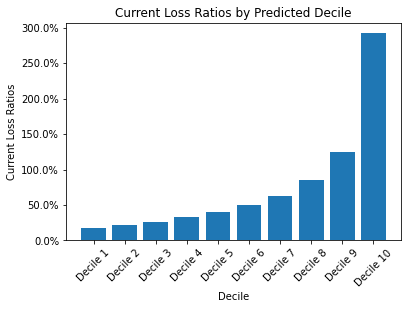

In [36]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

# Assuming you have a DataFrame named 'test_data_comb'
df = test_data_comb

# Step 1: Rank by decile
df["Decile"] = pd.qcut(df["prediction"], q=10, labels=False, duplicates="drop")

# Step 2: Calculate the ratio
df["Ratio"] = df["prediction"] / df["CurrentPremium"]

# Create a summary table
summary_table = (
    df.groupby("Decile").agg({"prediction": "sum", "CurrentPremium": "sum"}).reset_index()
)

# Rename columns in the summary table
summary_table = summary_table.rename(
    columns={"prediction": "Predicted Loss", "CurrentPremium": "Current Premium"}
)

# Add a total row to the summary table
total_row = summary_table.sum(numeric_only=True)
total_row["Decile"] = "Total"
summary_table = summary_table.append(total_row, ignore_index=True)

# Format numbers in the table to be in millions
summary_table["Predicted Loss"] = summary_table["Predicted Loss"] / 1e6  # Convert to millions
summary_table["Current Premium"] = summary_table["Current Premium"] / 1e6  # Convert to millions

# Display the summary table with million formatting and renamed columns
formatted_table = summary_table.copy()
formatted_table["Predicted Loss"] = formatted_table["Predicted Loss"].apply(lambda x: f"{x:.2f} M")
formatted_table["Current Premium"] = formatted_table["Current Premium"].apply(
    lambda x: f"{x:.2f} M"
)

print(formatted_table)

# Step 3: Create a bar chart histogram
decile_means = df.groupby("Decile")["Ratio"].mean()
decile_labels = [f"Decile {i+1}" for i in range(10)]

plt.bar(decile_labels, decile_means)
plt.xlabel("Decile")
plt.ylabel("Current Loss Ratios")
plt.title("Current Loss Ratios by Predicted Decile")

# Set the y-axis labels to be percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1))

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

## Compute actual and predicted loss ratios by various segments for business analysis

Analysts would like to understand loss ratios by various one-way segmentation of the portfolio.

Summary stats - Premium, Incurred Claims and Loss Ratios


,VehicleMake,IncurredClaims,CurrentPremium,PredPremium,Loss_Ratio_Current,Loss_Ratio_Pred,PremChg %
0,FORD,$2.34 M,$6.82 M,$5.71 M,34.4%,41.0%,-16.3%
1,HONDA,$3.42 M,$7.80 M,$7.46 M,43.8%,45.8%,-4.4%
2,HYUNDAI,$2.91 M,$2.84 M,$5.54 M,102.2%,52.4%,95.0%
3,MERCEDES-BENZ,$1.09 M,$3.55 M,$2.88 M,30.6%,37.7%,-18.8%
4,TOYOTA,$2.60 M,$2.55 M,$4.94 M,102.0%,52.6%,93.9%


Summary stats - Premium, Incurred Claims and Loss Ratios


,DistributionChannel,IncurredClaims,CurrentPremium,PredPremium,Loss_Ratio_Current,Loss_Ratio_Pred,PremChg %
0,Bankassurance,$0.73 M,$2.24 M,$1.92 M,32.4%,37.8%,-14.2%
1,Insurance Agency,$3.94 M,$9.02 M,$9.21 M,43.7%,42.8%,2.1%
2,Insurance Broker,$3.61 M,$8.64 M,$8.34 M,41.7%,43.3%,-3.5%
3,Vehicle Dealership,$2.40 M,$1.55 M,$4.09 M,155.1%,58.7%,164.2%
4,Web,$1.67 M,$2.11 M,$2.98 M,79.3%,56.2%,41.1%


Summary stats - Premium, Incurred Claims and Loss Ratios


,Gender,IncurredClaims,CurrentPremium,PredPremium,Loss_Ratio_Current,Loss_Ratio_Pred,PremChg %
0,C,$2.13 M,$1.56 M,$3.46 M,136.0%,61.5%,121.2%
1,F,$3.09 M,$8.23 M,$7.77 M,37.5%,39.8%,-5.6%
2,M,$7.09 M,$13.59 M,$15.13 M,52.2%,46.9%,11.3%


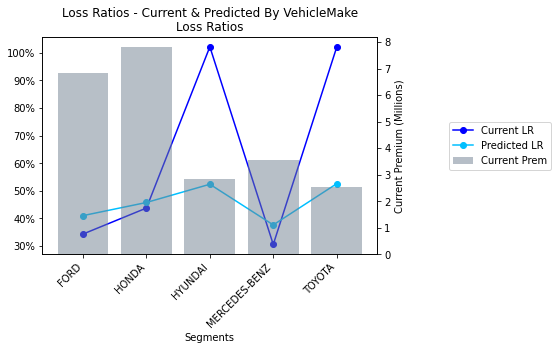

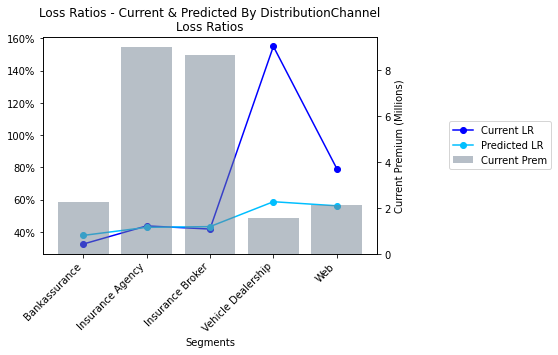

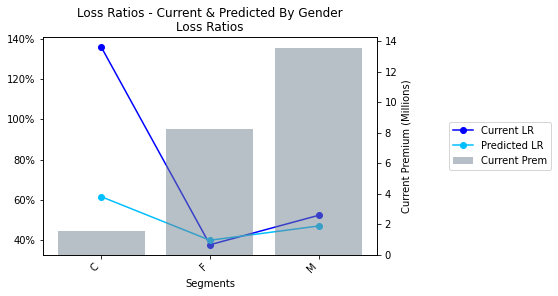

In [37]:
# Loss ratio analysis by segments

# This code calculates and visualizes the Current and Predicted Loss Ratios for various segments.
# Loss Ratio represents the ratio of Incurred Claims to Premium (Current and Predicted), providing insights into the
# profitability and risk associated with different segments. This analysis helps in understanding
# the relationship between claims and premiums and its impact on business decision-making.


# List of segments for loss ratio analysis for the user to analyse:
Segment_list = ["VehicleMake", "DistributionChannel", "Gender"]

# This Function Calculate and Visualize Loss Ratios for a Given Segment


def LossRatio(segment):
    # Group by 'Segment' column and calculate the sum of 'Value1' and 'Value2'
    grouped_df = test_data_comb.groupby(segment).agg(
        {"IncurredClaims": "sum", "CurrentPremium": "sum", "PredPremium": "sum"}
    )

    # Reset index to make the grouped column as a regular column
    grouped_df = grouped_df.reset_index()
    grouped_df["Loss_Ratio_Current"] = grouped_df["IncurredClaims"] / grouped_df["CurrentPremium"]
    grouped_df["Loss_Ratio_Pred"] = grouped_df["IncurredClaims"] / grouped_df["PredPremium"]
    grouped_df["PremChg %"] = grouped_df["PredPremium"] / grouped_df["CurrentPremium"] - 1

    grouped_df["IncurredClaims"] = grouped_df["IncurredClaims"] / 1000000
    grouped_df["CurrentPremium"] = grouped_df["CurrentPremium"] / 1000000
    grouped_df["PredPremium"] = grouped_df["PredPremium"] / 1000000

    # Prepare data for the plot
    segments = grouped_df[segment]
    value_ratio_pred = grouped_df["Loss_Ratio_Pred"]
    value_ratio_curr = grouped_df["Loss_Ratio_Current"]
    value1_sum = grouped_df["CurrentPremium"]

    # update formatting for readability in the tables:
    grouped_df["PremChg %"] = grouped_df["PremChg %"].apply(lambda x: f"{x * 100:.1f}%")
    grouped_df["Loss_Ratio_Pred"] = grouped_df["Loss_Ratio_Pred"].apply(lambda x: f"{x * 100:.1f}%")
    grouped_df["Loss_Ratio_Current"] = grouped_df["Loss_Ratio_Current"].apply(
        lambda x: f"{x * 100:.1f}%"
    )
    grouped_df["IncurredClaims"] = grouped_df["IncurredClaims"].apply(lambda x: f"${x:.2f} M")
    grouped_df["CurrentPremium"] = grouped_df["CurrentPremium"].apply(lambda x: f"${x:.2f} M")
    grouped_df["PredPremium"] = grouped_df["PredPremium"].apply(lambda x: f"${x:.2f} M")

    print("Summary stats - Premium, Incurred Claims and Loss Ratios")
    display(grouped_df)

    # Create a figure with two subplots
    fig, ax1 = plt.subplots()

    plt.title(
        f"Loss Ratios - Current & Predicted By {segment}", pad=20
    )  # Adjust the pad value as needed

    # Plot the ratio values as a line plot
    (line1,) = ax1.plot(
        range(len(grouped_df)), value_ratio_curr, marker="o", color="blue", label="Current LR"
    )
    (line2,) = ax1.plot(
        range(len(grouped_df)),
        value_ratio_pred,
        marker="o",
        color="deepskyblue",
        label="Predicted LR",
    )

    # Format the left-hand side y-axis as a percentage
    ax1.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

    # Create a twin axes sharing the x-axis
    ax2 = ax1.twinx()

    # Plot the sum of Value1 as a bar plot on top
    bar_chart = ax2.bar(
        range(len(grouped_df)), value1_sum, alpha=0.5, color="slategrey", label="Current Prem"
    )

    # Set x-axis labels and title
    ax1.set_xticks(range(len(grouped_df)))
    ax1.set_xticklabels(segments, rotation=45, ha="right")
    ax1.set_xlabel("Segments")
    plt.title("Loss Ratios")

    # Add legend with the new entry for "Current Premium"
    lines = [line1, line2, bar_chart]
    legend = ax1.legend(
        lines, [line.get_label() for line in lines], loc="center left", bbox_to_anchor=(1.2, 0.5)
    )

    ax2.set_ylabel("Current Premium (Millions)")


# Loop through the specified segments and analyze loss ratios for each.

for x in Segment_list:
    LossRatio(x)

## Premium dislocation and impact anaylsis

Create a dislocation premium chart of the impact of the new proposed pricing structure.

In [ ]:
# This script is designed for pricing analysis in insurance. It calculates and visualizes premium change percentages for the proposed pricing
# Understanding premium changes is vital for making informed pricing decisions, evaluating model performance, and assessing competitiveness.
# The code displays a histogram with the mean value as a reference and provides a table with policy count breakdown in each bin.

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate


def calculate_dislocation(data, titlex):
    # Calculate the premium change percentage
    data["PremiumChg"] = (data["PredPremium"] / data["CurrentPremium"]) - 1

    # Define the bin edges for the histogram
    bin_edges = np.linspace(-1, 1, num=11)  # Create 10 equally spaced bins between -1 and 1

    # Clip values outside the range -100% to +100% into the corresponding bins
    data["PremiumChg"] = np.clip(data["PremiumChg"], -1, 1)

    # Create a histogram of premium change percentages
    counts, bin_edges, _ = plt.hist(
        data["PremiumChg"], bins=bin_edges, alpha=0.7, color="blue", edgecolor="black"
    )

    # Calculate the mean of PremiumCh


def calculate_dislocation(data, titlex):
    # Calculate the premium change percentage
    data["PremiumChg"] = (data["PredPremium"] / data["CurrentPremium"]) - 1

    # Define the bin edges for the histogram
    bin_edges = np.linspace(-1, 2, num=11)  # Create 10 equally spaced bins between -1 and 1

    # Clip values outside the range -100% to +100% into the corresponding bins
    data["PremiumChg"] = np.clip(data["PremiumChg"], -1, 2)

    # Create a histogram of premium change percentages
    counts, _, _ = plt.hist(
        data["PremiumChg"], bins=bin_edges, alpha=0.7, color="blue", edgecolor="black"
    )

    # Calculate the mean of PremiumChg
    mean_premium_chg = data["PremiumChg"].mean()

    # Set x-axis labels, y-axis labels, and title
    plt.xlabel("Premium Impact %")
    plt.ylabel("Policy Count")
    plt.title(titlex)

    # Add a vertical line at the mean value
    plt.axvline(
        mean_premium_chg,
        color="red",
        linestyle="dashed",
        linewidth=2,
        label=f"Mean: {mean_premium_chg:.2f}",
    )

    # Display the plot
    plt.legend()
    plt.show()


# Assuming you have a DataFrame called 'test_data_comb' containing the dataset
# Display the histogram for the entire dataset
calculate_dislocation(test_data_comb, "Premium Dislocation - Total Portfolio")

# Display the histogram for the sliced dataset
loyal = test_data_comb[test_data_comb["CustomerTenure"] > 5]
calculate_dislocation(loyal, "Premium Dislocation - Loyal Customers 5+")

# Display the histogram for the sliced dataset
new = test_data_comb[test_data_comb["CustomerTenure"] == 0]
calculate_dislocation(new, "Premium Dislocation - New Customers ")

## Deployment of the model

After identifying the best-performing models, you can deploy them and use DataRobot's REST API to make HTTP requests and return predictions. You can also configure batch jobs to write back into the environment of choice.

Once deployed, access monitoring capabilities such as:

- Service health
- Prediction accuracy
- Model retraining

In [55]:
# Copy and paste the model ID from previous steps or from UI

# Uncomment To access an existing project set your project ID below
# project = dr.Project.get("648c265acf92fc20e21ae8bf")

# Set the 'project' variable to the Incurred Loss project we want to use.
project = ic_project

# Retrieve the top model from the specified project.
top_model = project.get_top_model()

model_id = top_model.id
prediction_server = dr.PredictionServer.list()[0]

deployment = dr.Deployment.create_from_learning_model(
    model_id,
    label="Insurance Pricing Demo Deployment",
    description="Insurance Pricing Alert Demo using API",
    default_prediction_server_id=prediction_server.id,
)

deployment
deployment.get_uri()

'https://app.datarobot.com/deployments/657c93e85ed5afdb276dee94/overview'

## Make predictions with a deployment


In [62]:
# This is a different step than for training, we need to transform the original dataset to be adequate for scoring purposes


# grab a subset of data to illustrate scoring against a deployment
scoring_data = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/insurance/Car+Insurance+Demo+scoring.csv"
)

# apply similar transformation to scoring data required:

# Data Preprocessing:
# 1. Convert date columns to datetime objects for consistency and analysis.
scoring_data["EffectiveDate"] = pd.to_datetime(scoring_data["EffectiveDate"])
scoring_data["DriverDoB"] = pd.to_datetime(scoring_data["DriverDoB"])
scoring_data["EndDate"] = pd.to_datetime(scoring_data["EndDate"])

# 2. Setting the exposure to 1 for scoring purposes  - we want the prediction to represent a full year premium
scoring_data["Exposure"] = 1

# 3. Calculate 'VehicleAge' as the difference between the underwriting year and the vehicle's model year.
scoring_data["VehicleAge"] = scoring_data["EffectiveDate"].dt.year - scoring_data["ModelYear"]

# 4. Set negative 'VehicleAge' values to 0, assuming a new vehicle.
scoring_data["VehicleAge"] = np.where(scoring_data["VehicleAge"] < 0, 0, scoring_data["VehicleAge"])

# 5. Drop the original 'ModelYear' column as 'VehicleAge' now captures the same information.
scoring_data.drop(["ModelYear"], axis=1, inplace=True)

# 6. Calculate 'DriverAge' based on the difference between the policy's effective date and the driver's date of birth.
scoring_data["DriverAge"] = (scoring_data["EffectiveDate"] - scoring_data["DriverDoB"]).astype(
    "<m8[Y]"
)

# 7. Create an 'NCB_offset' feature based on the No Claim Bonus (NCB) discounts.

# The 'NCB_offset' adjusts the model for NCB, particularly for regression problems using the log link function.
scoring_data["NCB_offset"] = np.log((100 - scoring_data["NoClaimBonus"]) / 100)

# 8. Create underwriting year feature
scoring_data["UWYEar"] = scoring_data["EffectiveDate"].dt.year

### Batch predictions

Batch predictions are made via the API.

In [63]:
# The input file will be streamed to our API and scoring will start immediately.
# As soon as results start coming in, we will initiate the download concurrently.

dr.BatchPredictionJob.score(
    deployment,
    intake_settings={
        "type": "localFile",
        "file": scoring_data,  # Path or Pandas or file-like object
    },
    output_settings={"type": "localFile", "path": "api_predictions.csv"},
    skip_drift_tracking=True,
)

BatchPredictionJob(batchPredictions, '657c9984b32470b28defc7ec', status=INITIALIZING)

## Extact Rating Tables for the top model from the Incurred Claims Project

It might be easier to download coefficient and rating tables from the project to integrate in external pricing engines, or to provide information for regulation purposes.

This section provides API code to be able to download and manipulate rating tables accordingly.

In [47]:
# Retrieve the top model from the specified project.
top_model = project.get_top_model()

# project id
pid = ic_project.id

# model id
# Ensure the model has rating table functionality

mid = top_model.id

In [48]:
def download_rating_table(pid, mid):
    """Download the rating table corresponding to the pid and mid"""
    project = dr.Project.get(pid)
    rating_tables = rating_tables = project.get_rating_tables()
    rating_table = [rt for rt in rating_tables if rt.model_id == mid][0]
    filepath = "./my_rating_table_" + mid + ".csv"
    rating_table.download("./my_rating_table_" + mid + ".csv")
    print(rating_table)
    return filepath


def csv_after_emptylines(filepath, bl_group_n=1, dtype=str):
    """Read a .CSV into a Pandas DataFrame, but only after at least one blank line has been skipped.
    bl_group_n is the expected number of distinct blocks of blank lines (of any number of rows each) to skip before reading data.
    NB: E.g. pd.read_csv(filepath, skiprows=[0, 1, 2]) works if you know the number of rows to be skipped. Use this function if you have a variable / unknown number of filled rows (to be skipped / ignored) before the empty rows.
    """
    with open(filepath, newline="") as f:
        blank_lines = 0
        bl_groups = 0
        contents = []
        headers = None
        r = csv.reader(f)
        for i, l in enumerate(r):
            if bl_groups < bl_group_n:
                if not l:
                    blank_lines += 1
                    continue
                if blank_lines == 0:
                    continue
                bl_groups += 1
                blank_lines = 0
                headers = l
                continue
            contents.append(l)
        return pd.DataFrame(data=contents, columns=headers, dtype=dtype)


def csv_until_emptyline(filepath, dtype=str):
    """Read a .CSV into a Pandas DataFrame until a blank line is found, then stop."""
    with open(filepath, newline="") as f:
        contents = []
        r = csv.reader(f)
        for i, l in enumerate(r):
            if not l:
                break
            if i == 0:
                headers = l
                continue
            contents.append(l)
        return pd.DataFrame(data=contents)


def extract_base(filepath):
    """Read a .CSV into a Pandas DataFrame until a blank line is found, then stop.
    Extract base value and return it
    """
    df = csv_until_emptyline(filepath)
    df.rename(columns={df.columns[0]: "raw"}, inplace=True)
    df[["name", "value"]] = df["raw"].str.split(":", expand=True)
    base_premium = pd.to_numeric(df.loc[df.name == "Base", "value"].values[0])
    print(base_premium)
    return base_premium


def get_rating_table(pid, mid):
    """Download rating table for a particular pid and mid and return scorecard"""
    filepath = download_rating_table(pid, mid)
    rating_table_raw = csv_after_emptylines(filepath)
    base_raw = extract_base(filepath)
    return base_raw, rating_table_raw

In [49]:
filepath = download_rating_table(pid, mid)
rating_table_raw = csv_after_emptylines(filepath)
base_premium = extract_base(filepath)
print("------------------------------------")
print(f"The base premium is: {base_premium}")
print("------------------------------------")
print(
    "Rating table relativity for model : "
    + "https://app.datarobot.com/projects/"
    + pid
    + "/models/"
    + mid
)
display(rating_table_raw)

RatingTable(Rating Table for 657c7558aad79499706a5a28)
395.6300233601683
------------------------------------
The base premium is: 395.6300233601683
------------------------------------
Rating table relativity for model : https://app.datarobot.com/projects/657c74d4362787498d4ced25/models/657c7558aad79499706a5a28


,Feature Name,Feature Strength,Type,Transform1,Value1,Transform2,Value2,Weight,Coefficient,Relativity
0,CustomerTenure,0.08707842242845597,NUM,Binning,"(-inf, 1]",,,7446.0,0.16357260919370878,1.1777108647193049
1,CustomerTenure,0.08707842242845597,NUM,Binning,"(1, 2]",,,2819.0,0.16468375289904144,1.1790201980273582
2,CustomerTenure,0.08707842242845597,NUM,Binning,"(2, 3]",,,2309.0,0.0034711583574232414,1.0034771898042776
3,CustomerTenure,0.08707842242845597,NUM,Binning,"(3, 4]",,,1951.0,-0.007470101065274679,0.9925577307943003
4,CustomerTenure,0.08707842242845597,NUM,Binning,"(4, 6]",,,2938.0,-0.04670227647458898,0.9543714941429471
...,...,...,...,...,...,...,...,...,...,...
1568,( DistributionChannel & PostCode_Aged_60 ),0.014853598055045778,2W-INT,One-hot,Bankassurance,Binning,Missing Value,0.0,-0.004670367681163238,0.9953405215271774
1569,( DistributionChannel & PostCode_Aged_60 ),0.014853598055045778,2W-INT,One-hot,Vehicle Dealership,Binning,Missing Value,0.0,0.016301122270439127,1.0164347104560691
1570,( DistributionChannel & PostCode_Aged_60 ),0.014853598055045778,2W-INT,One-hot,Web,Binning,Missing Value,0.0,0.012209598034279043,1.0122844394607695
1571,( DistributionChannel & PostCode_Aged_60 ),0.014853598055045778,2W-INT,One-hot,Insurance Broker,Binning,Missing Value,0.0,0.0007349651494303588,1.000735235302496


## Upload an existing rating table

This workflows allows you to upload an existing rating table to the Leaderboard.

Specific formatting is essential for the rating table to be uploaded, detailed in the  [DataRobot documentation](https://docs.datarobot.com/en/docs/modeling/analyze-models/describe/rating-table.html).

In [50]:
# Display current rating table
filepath = "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/insurance/ratingtable_new.csv"
current_rating_table = pd.read_csv(filepath)
display(current_rating_table)

job = dr.RatingTable.create(pid, mid, filepath)
new_rating_table = job.get_result_when_complete()
job = new_rating_table.create_model()
model = job.get_result_when_complete()

,Total weights: 22931,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Intercept: 5.980479490094718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Base: 395.6300233601683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Model precision: single,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Offset: NCB_offset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Exposure: Exposure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1588,( DistributionChannel & PostCode_Aged_60 ),0.014853598,2W-INT,One-hot,Bankassurance,Binning,Missing Value,0,-0.004670368,0.995340522
1589,( DistributionChannel & PostCode_Aged_60 ),0.014853598,2W-INT,One-hot,Vehicle Dealership,Binning,Missing Value,0,0.016301122,1.01643471
1590,( DistributionChannel & PostCode_Aged_60 ),0.014853598,2W-INT,One-hot,Web,Binning,Missing Value,0,0.012209598,1.012284439
1591,( DistributionChannel & PostCode_Aged_60 ),0.014853598,2W-INT,One-hot,Insurance Broker,Binning,Missing Value,0,0.000734965,1.000735235


### Other types of scoring methods

DataRobot offers many ways to score models, from real time preidctions, to downloading Scoring Code, to portable predictions.

A lot of these options are how insurers integrate in various raing engine and optimiser solution.

Refer to the [DataRobot documentation](https://docs.datarobot.com/en/docs/predictions/index.html) on predictions methodology.

## Advanced workflow 

### Feature discovery with secondary claims database

The scope of this section is to provide an end to end example of how to use Feature Discovery with DataRobot Python API.

#### Background

Feature Discovery is used to automatically aggregate data of different granularities while generating hundreds of features. This can significantly reduce the time investment needed from data scientists and data engineers alike to bring data together and start modeling. 

In an insurance context, this could be useful to understand how hsitorical claims can impact pricing and suggest multiple different claims related feature for pricing.

### Configure time-aware feature engineering

To set up a Feature Discovery project from the API, you want to create a DataRobot project object so you can define all of the relationships between datasets.

Create the project with the primary dataset (this will always have your target variable), provide database credentials, and a project name.

Configure which feature engineering operators should be explored during Feature Discovery across datasets.

In [120]:
# ASSUME CLAIM HISTORY IS AVAILABLE BOTH FOR NEW AND EXISTING CUSTOMERS - CENTRALISED CLAIM SYSTEM

### Create a DataRobot project

In [316]:
dataset_target = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/insurance/pol_primary_exncb.csv"
)
dataset_target.head(5)

,Exposure,Customer_ID,EffectiveDate,EndDate,SumInsured,VehicleMake,VehicleModel,EngineCapacity,ModelYear,ClientType,...,PostCode_Aged_50_59,PostCode_Aged_60,PostCode_PersonsPerDwelling,PostCode_annualKm,PostCode_VehiclesPerDwelling,PostCode_CommuteViaCar,DistributionChannel,SydneyRegion,ClaimCount,IncurredClaims
0,1.00,800505,06/11/2022,05/11/2023,10000,FORD,Laser,1498,2006,Retail,...,0.147224,0.205627,2.576153,3097.966487,1.119539,0.45,Vehicle Dealership,Y,0,0.000000
1,0.59,800507,17/09/2021,19/04/2022,60000,FORD,Ranger,2499,2018,Commercial,...,0.176782,0.117424,2.913913,7907.912116,1.349719,0.57,Bankassurance,Y,1,5490.776739
2,1.00,800508,01/05/2021,30/04/2022,180000,MERCEDES-BENZ,E240,2597,2016,Retail,...,0.169521,0.149333,2.645607,5386.260500,1.260063,0.54,Insurance Broker,Y,0,0.000000
3,1.00,800509,24/04/2022,23/04/2023,16000,TOYOTA,Corolla,1587,2004,Retail,...,0.139648,0.213989,2.047232,2726.648724,0.969438,0.43,Insurance Agency,Y,0,0.000000
4,1.00,800510,01/02/2022,31/01/2023,130000,HYUNDAI,Sonata,1998,2020,Commercial,...,0.099873,0.076382,1.704806,4342.885256,0.550485,0.24,Vehicle Dealership,Y,0,0.000000


In [317]:
path_pol = "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/insurance/pol_primary_exncb.csv"
path_claim = "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/insurance/claims_history.csv"

df_pol = pd.read_csv(path_pol)
df_claim = pd.read_csv(path_claim)

# Data Transformation

# Remove policies with negative exposure or 0 exposure
df_pol.drop(df_pol[df_pol["Exposure"] <= 0].index, inplace=True)

# Reassign negative values from Incurred to zero or decide other treatment for negative values
df_pol["IncurredClaims"] = np.where(df_pol["IncurredClaims"] < 0, 0, df_pol["IncurredClaims"])

# Create a dataset using a pandas DataFrame
dataset_target = dr.Dataset.upload(df_pol)
dataset_claims = dr.Dataset.upload(df_claim)


ic_featdisc_project = dr.Project.create_from_dataset(
    dataset_target.id,  # unique ID of the target dataset we just created
    project_name="Incurred Claims Feature Discovery",
)

In [114]:
df_claim.head(5)

,Customer_ID,Claim Number,AccidentDate,ReportDate,ClosedDate,Collision Category,Vehicle Make 3rd,Claim Status,Adjuster Name,Accident Location,Police Report Filed,Claim Amount
0,800507,43619854,03/09/2019,31/08/2019,21/10/2019,Multi-Vehicle Collision,BMW,Settled,Ryan Baker,"63637 Ryan Ridges Suite 867, Rhondabury, FL 19382",No,5644
1,800508,25277288,07/06/2020,12/05/2020,11/06/2020,Rear-end Collision,Ford,Settled,Michael Hawkins,"7777 Montes Islands Apt. 924, New Jaimemouth, ...",No,1532
2,800510,69455337,18/04/2020,04/04/2020,03/06/2020,Side Collision,Honda,Pending,Angela Butler DVM,"462 Johns Prairie, New Michelleton, PA 09310",No,2079
3,800513,69051116,13/11/2021,10/11/2021,05/01/2022,Pedestrian or Cyclist Collision,Toyota,Denied,Dr. Gloria Martinez,"0533 Chase Rest Suite 350, Andrewmouth, MS 66803",No,3225
4,800517,1796794,18/05/2021,19/04/2021,14/06/2021,Pedestrian or Cyclist Collision,Toyota,Denied,Sean Castillo,"099 Jennifer Knolls Suite 440, Armstrongtown, ...",Yes,4042


Store your Feature Discovery settings as a variable, which can be passed to a project's Advanced Options before you start building features and modeling. The time windows to derive these is defined in later cells. This is very useful if you want to constrain or experiment certain feature derivation types. Importantly, this list uses only non-UDF features, which can be exported and executed via Spark SQL.

In [318]:
# Define the type of feature engineering you want to explore
feature_discovery_settings_no_udf = [
    {"name": "enable_days_from_prediction_point", "value": True},
    {"name": "enable_hour", "value": True},
    {"name": "enable_categorical_num_unique", "value": True},
    {"name": "enable_categorical_statistics", "value": False},
    {"name": "enable_numeric_minimum", "value": True},
    {"name": "enable_token_counts", "value": False},
    {"name": "enable_latest_value", "value": True},
    {"name": "enable_numeric_standard_deviation", "value": True},
    {"name": "enable_numeric_skewness", "value": False},
    {"name": "enable_day_of_week", "value": True},
    {"name": "enable_entropy", "value": False},
    {"name": "enable_numeric_median", "value": True},
    {"name": "enable_word_count", "value": False},
    {"name": "enable_pairwise_time_difference", "value": True},
    {"name": "enable_days_since_previous_event", "value": True},
    {"name": "enable_numeric_maximum", "value": True},
    {"name": "enable_numeric_kurtosis", "value": False},
    {"name": "enable_most_frequent", "value": False},
    {"name": "enable_day", "value": True},
    {"name": "enable_numeric_average", "value": True},
    {"name": "enable_summarized_counts", "value": False},
    {"name": "enable_missing_count", "value": True},
    {"name": "enable_record_count", "value": True},
    {"name": "enable_numeric_sum", "value": True},
]

### Define the relationships between datasets

Define relationships between datasets for joins and the primary time field to ensure correct time-awareness for feature engineering. DataRobot will automatically handle variations in time data between datasets (e.g. minutes--> hours). The following snippet defines how each dataset relates to each other, and how far back in time to derive features.

Specify the relationships (join-keys) between the secondary and primary datasets, and the Feature Derivation Window (FDW) to explore.

You can have multiple relationships between datasets (e.g., a join on customer ID and a separate join on Claims to look at aggregate behavior at the claims vs. customer level).
The 'primary_temporal_key' will be the date-time field used to respect the prediction point (defined at project start).

You can define multiple time windows to explore long and short-term effects. For further reading, reference the documentation for Feature Discovery.

In [321]:
# Store the dataset AI Catalog IDs as a variable for simplicity

claims_catalog_id = dataset_claims.id
claims_catalog_version_id = dataset_claims.version_id

# Define the secondary datasets
# Defines the dataset identifier, temporal key, and snapshot policy for the secondary datasets

claims_dataset_definition = dr.DatasetDefinition(
    identifier="Claim",
    catalog_id=claims_catalog_id,
    catalog_version_id=claims_catalog_version_id,
    primary_temporal_key="AccidentDate",
)

# You do not need to specify dataset1Identifier when joining with the primary dataset
primary_claims_relationship = dr.Relationship(  # join primary dataset
    dataset2_identifier="Claim",  # to profile
    dataset1_keys=["Customer_ID"],  # on CustomerID
    dataset2_keys=["Customer_ID"],
    # feature_derivation_window_start=-5,
    # feature_derivation_window_end=0,
    # feature_derivation_window_time_unit='YEAR', #example of single FDW
    feature_derivation_windows=[
        {"start": -5, "end": 0, "unit": "YEAR"},
        {"start": -3, "end": 0, "unit": "YEAR"},
        {"start": -1, "end": 0, "unit": "YEAR"},
    ],  # example of multiple FDW
    prediction_point_rounding=1,
    prediction_point_rounding_time_unit="DAY",
)

# Store datasets and relationships as a list for config settings
dataset_definitions = [claims_dataset_definition]
relationships = [primary_claims_relationship]

In [322]:
# Create the relationships configuration to define the connection between the datasets
# This will be passed to the DataRobot project configuration for Autopilot
relationship_config = dr.RelationshipsConfiguration.create(
    dataset_definitions=dataset_definitions,
    relationships=relationships,
    feature_discovery_settings=feature_discovery_settings_no_udf,
)

## Build models

So far you have:

- Registered your datasets in the AI Catalog and defined their relationships
- Defined the types of feature engineering and time frames to explore

This configuration is stored in time and can be reused. To start modeling, you want to:

- pass the newly defined relationship config from above
- note: The first line toggles Supervised Feature Reduction (SFR). The Feature Discovery step creates and explores a wide range of features (can be hundreds or thousands), and SFR will intelligently weed out low-information features. The remaining features will be formed into one dataset of candidate features in your project (which you will further reduce)

Once complete, you will initiate Autopilot with DataRobot to build models.

In [323]:
# partitioning_spec = dr.DatetimePartitioningSpecification('date')
# You can use prediction point instead

# CREATE A DF FROM THE FEATURES, ITERATING THROUGH A LIST & COMPILING A DICT
informative = [
    feat_list
    for feat_list in ic_featdisc_project.get_featurelists()
    if feat_list.name == "Informative Features"
][0]

# UPDATE FEATURE LIST BY SUBTRACTING PARENTS, AND ADDING NEW VARS
new_fl = ic_featdisc_project.create_featurelist(
    "new_fl",
    list(
        (
            set(informative.features)
            - {"EffectiveDate"}
            - {"EndDate"}
            - {"NoClaimBonus"}
            - {"DriverDoB"}
            - {"CurrentPremium"}
        )
    ),
)


# SFR default is True, shown here as an example of how to set SFR using the API
advanced_options = dr.AdvancedOptions(
    feature_discovery_supervised_feature_reduction=True,
    seed=RANDOM_SEED,
    exposure="Exposure",
    events_count="ClaimCount",
)

ic_featdisc_project.analyze_and_model(
    target="IncurredClaims",
    relationships_configuration_id=relationship_config.id,
    feature_engineering_prediction_point="EffectiveDate",  # The prediction point is defined here. This maps to the 'primary_temporal_key' in the Relationship Config above
    advanced_options=advanced_options,
    featurelist_id=new_fl.id,
)


ic_featdisc_project.set_worker_count(-1)  # Use all available workers

# Wait for them to complete
ic_featdisc_project.wait_for_autopilot()

In progress: 10, queued: 0 (waited: 0s)
In progress: 10, queued: 0 (waited: 1s)
In progress: 10, queued: 0 (waited: 2s)
In progress: 10, queued: 0 (waited: 3s)
In progress: 10, queued: 0 (waited: 5s)
In progress: 10, queued: 0 (waited: 7s)
In progress: 10, queued: 0 (waited: 11s)
In progress: 10, queued: 0 (waited: 18s)
In progress: 10, queued: 0 (waited: 32s)
In progress: 10, queued: 0 (waited: 53s)
In progress: 8, queued: 0 (waited: 74s)
In progress: 6, queued: 0 (waited: 94s)
In progress: 6, queued: 0 (waited: 115s)
In progress: 5, queued: 0 (waited: 136s)
In progress: 5, queued: 0 (waited: 157s)
In progress: 4, queued: 0 (waited: 178s)
In progress: 3, queued: 0 (waited: 198s)
In progress: 3, queued: 0 (waited: 219s)
In progress: 2, queued: 0 (waited: 240s)
In progress: 2, queued: 0 (waited: 261s)
In progress: 1, queued: 0 (waited: 282s)
In progress: 0, queued: 0 (waited: 303s)
In progress: 0, queued: 0 (waited: 323s)
In progress: 0, queued: 0 (waited: 344s)
In progress: 0, queued: 